In [1]:
import torch
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os

from model.net import *
from utils.training import *
from data.data import *

## Experiment Config

In [2]:
model_path = os.getcwd()

args = {
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 30,
    'LEARNING_RATE': 0.01,
    'MOMENTUM': 0.9,
    'DATASET_NAME':'mnist',
    'LAMBDA_recon': 1, #0.0005
    'LAMBDA_margin': 0,
    'LReLU_negative_slope':0.1,
}

## Model Loading

In [3]:
#Modified Reconstructor

class Reconstructor(nn.Module):
    def __init__(self, net):
        super(Reconstructor, self).__init__()
        self.input_width = net.decoder.input_width
        self.input_height = net.decoder.input_height
        self.input_channel = net.decoder.input_channel
        self.reconstraction_layers = net.decoder.reconstraction_layers
        self.mean = torch.tensor(0.1307)
        self.std = torch.tensor(0.3081)
        if(args['USE_CUDA']):
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.normalize = Normalize(self.mean, self.std)
        
#     def forward(self, x, data):
# #         classes = torch.sqrt((x ** 2).sum(2))
# #         classes = F.softmax(classes.squeeze(), dim=1)
# #         _, max_length_indices = classes.max(dim=1)
#         eye = torch.sparse.torch.eye(10)
#         if USE_CUDA:
#             eye = eye.cuda()
#         reconstructions_of_digits = []
#         for i in range(0,x.size(1)):
#             index_list = torch.ones((x.size(0), ),dtype=torch.int64).cuda()*i
#             masked = eye.index_select(dim=0, index=index_list)
#             reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))
        
#         reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) #shape = [B, 10, 28*28*1]
#         expanded_data = data.view(x.size(0), 1, -1).expand(-1, x.size(1), -1)
#         reconstructions_of_digits = self.unnormalize(reconstructions_of_digits)
#         l2_distances = torch.square((expanded_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
# #         reconstructions = reconstructions.view(-1, x.size(1), self.input_channel, self.input_width, self.input_height)
#         return l2_distances

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes.squeeze(), dim=1)
        _, max_length_indices = classes.max(dim=1)
        max_length_indices_2 = 9 - max_length_indices
        eye = torch.sparse.torch.eye(10)
        if USE_CUDA:
            eye = eye.cuda()
        reconstructions_of_digits = []
        for index_list in [max_length_indices]:#, max_length_indices_2]:
            masked = eye.index_select(dim=0, index=index_list.squeeze().data)
            reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

        reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) #shape = [B, 2, 28*28*1]
        expanded_data = data.view(x.size(0), 1, -1).expand(-1, 2, -1)
        reconstructions_of_digits = self.normalize(reconstructions_of_digits)
        l2_distances = torch.square((expanded_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
        return l2_distances

In [4]:
#Config for 49 16d vectors in the Primary Capsule. Set Softmax dimension to 0 in this case
class Config:
    def __init__(self):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 12
        self.cnn_kernel_size = 15

        # Primary Capsule (pc)
        self.pc_num_capsules = 16
        self.pc_in_channels = 12
        self.pc_out_channels = 1
        self.pc_kernel_size = 8
        self.pc_num_routes = 1 * 7 * 7

        # Digit Capsule 1 (dc)
        self.dc_num_capsules = 49
        self.dc_num_routes = 1 * 7 * 7
        self.dc_in_channels = 16
        self.dc_out_channels = 16
        
        # Digit Capsule 2 (dc)
        self.dc_2_num_capsules = 10
        self.dc_2_num_routes = 1 * 7 * 7
        self.dc_2_in_channels = 16
        self.dc_2_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28

torch.manual_seed(1)
config = Config()

net = CapsNet(args, config)
# capsule_net = torch.nn.DataParallel(capsule_net)
if args['USE_CUDA']:
    net = net.cuda()
    
net.load_state_dict(torch.load(os.path.join(model_path, 'CapsNetMNIST_Recon.pth'), map_location='cpu'))

<All keys matched successfully>

## Loading Dataset

In [5]:
trainloader, testloader = dataset(args)

##  The histogram of L2 distances between the input and the reconstruction using the
## correct capsule or other capsules in CapsNet on the real MNIST images. 

In [6]:
import matplotlib.pyplot as plt

def L2_Cor_Incor_Capsules(model, reconstructor, train_loader, args):
    net = model
    net.eval()
    n_batch = len(train_loader)
    l2_distances = []
    with torch.no_grad():
        for batch_id, (data, target) in enumerate(tqdm(train_loader)):
            if(args['USE_CUDA']):
                data = data.cuda()

            output, _, _ = net(data)
            l2_distances.append(reconstructor(output, data).view(-1, ))
    
    return torch.cat(l2_distances, dim=0).cpu().numpy()

def plot_hist(l2_distances, num_bins=140):
    fig, ax = plt.subplots()

    # the histogram of the data
    n, bins, patches = ax.hist(l2_distances, num_bins)

    ax.set_xlabel('l2_distances')
    ax.set_ylabel('Samples')
    ax.set_title('L2 Distances input and recons')

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

100%|██████████| 40/40 [00:03<00:00, 12.94it/s]


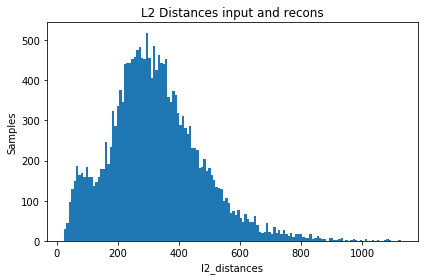

In [8]:
recon = Reconstructor(net)
l2_distances = L2_Cor_Incor_Capsules(net, recon, testloader, args)
plot_hist(l2_distances, num_bins=140)

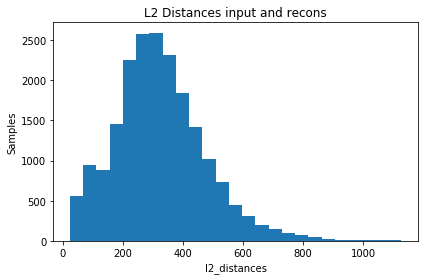

In [10]:
plot_hist(l2_distances, num_bins=25)

In [9]:
l2_distances.shape

(120000,)

In [ ]:
# torch.save(capsule_net.state_dict(), "./CapsNetMNIST.pth")

In [ ]:
#Config for 16 1d vectors in Capsule Layer. Set the Softmax Dimension to 1 in this case
# class Config:
#     def __init__(self, dataset='mnist'):
#         # CNN (cnn)
#         self.cnn_in_channels = 1
#         self.cnn_out_channels = 12
#         self.cnn_kernel_size = 15

#         # Primary Capsule (pc)
#         self.pc_num_capsules = 1
#         self.pc_in_channels = 12
#         self.pc_out_channels = 16
#         self.pc_kernel_size = 8
#         self.pc_num_routes = 16 * 7 * 7

#         # Digit Capsule 1 (dc)
#         self.dc_num_capsules = 49
#         self.dc_num_routes = 16 * 7 * 7
#         self.dc_in_channels = 1
#         self.dc_out_channels = 1 #16
        
#         # Digit Capsule 2 (dc)
#         self.dc_2_num_capsules = 10
#         self.dc_2_num_routes = 7 * 7
#         self.dc_2_in_channels = 1 #16
#         self.dc_2_out_channels = 16

#         # Decoder
#         self.input_width = 28
#         self.input_height = 28